In [1]:
#bulk RNA-seq
import os
os.chdir("D:/360MoveData/Users/dgwei/Desktop/BASIC/bulk_RNAseq/")
from plotly.offline import plot
from IPython.display import IFrame
import pandas as pd
import numpy as np
import shutil#os模块的补充，提供了复制、移动、删除、压缩、解压等操作
from tabulate import tabulate#打印漂亮的表格数据
import matplotlib.pyplot as plt

In [2]:
#常规和非常规不连续转录得到的reads
orfcolors = pd.read_csv('PEDV-colorcode-rainbow.txt', sep=' ', names=['orf', 'color'], index_col=0)['color'].to_dict()
annotations= pd.read_csv('reference/PEDV-annotations.gff', sep='\t', names=['chrom', 'type', 'name', 'start', 'end', '_x', '_y', '_z'])
annotations['start'] -= 1
cdsanno = annotations[(annotations['type'] == 'CDS') & (~annotations['name'].isin(['ORF10', 'nsp1', 'frameshift'])) & (~annotations['name'].apply(lambda x: x.startswith('nsp')))]
cdsanno = pd.concat([cdsanno,pd.DataFrame([pd.Series(['MK584552.1', 'CDS', 'ORF1a',  293, 12601, 0.0, '.', '.'], index=cdsanno.columns),pd.Series(['MK584552.1', 'CDS', 'ORF1b', 12601,20637, 0.0, '.', '.'], index=cdsanno.columns),])
]).sort_values(by='start').reset_index(drop=True).iloc[:, :5]
cdsanno

,chrom,type,name,start,end
0,MK584552.1,CDS,ORF1a,293,12601
1,MK584552.1,CDS,ORF1b,12601,20637
2,MK584552.1,CDS,S,20633,24791
3,MK584552.1,CDS,ORF3a,24790,25465
4,MK584552.1,CDS,E,25445,25676
5,MK584552.1,CDS,M,25683,26364
6,MK584552.1,CDS,N,26375,27701


In [3]:
largedels_mgi = pd.read_csv('result/PEDV-luo-invirion/PEDV.jumps.txt', names=['j5', 'j3', 'count'], sep='\t')
len(largedels_mgi)

44317

In [4]:
from Bio import SeqIO, Seq
covseq = str(next(SeqIO.parse('result/MK584552.1.fasta','fasta')).seq)

In [5]:
#对 largedels_mgi 中的每一行进行基因组序列分析，并将结果存储在 largedel_anno DataFrame 中。包括对基因组序列进行切片，查找起始密码子位置，计算蛋白质产物大小等操作
SNEEKSIZE = 12
largedel_anno = []

for _, row in largedels_mgi.iterrows():
    seqleft = covseq[:row.j5]
    seqright = covseq[row.j3:]
    seqrecomb = seqleft + seqright

    if 'ATG' in seqrecomb:
        # calculate start codon positions
        startpos_recomb = seqrecomb.find('ATG')
        if startpos_recomb < row.j5:
            startpos = startpos_recomb
        else:
            startpos = startpos_recomb - row.j5 + row.j3

        # calculate protein product size
        orfcandseq = seqrecomb[startpos_recomb:]
        if len(orfcandseq) % 3 > 0:
            orfcandseq += 'N' * (3 - len(orfcandseq) % 3)

        translation = Seq.Seq(orfcandseq).translate().split('*')[0]
        #if row['name'] == 'j2':
        #    print(Seq(orfcandseq).translate())
        product_size = len(translation)
    else:
        startpos_recomb = -1
        startpos = -1
        product_size = 0
        translation = ''

    #recombseq = covseq[row.j5 - SNEEKSIZE:row.j5].lower() + (
    #    covseq[row.j3:row.j3 + SNEEKSIZE])

    largedel_anno.append([row['j5'], row['j3'], row['count'],
                          startpos, product_size])

largedel_anno = pd.DataFrame(largedel_anno, columns=[
    'j5', 'j3', 'count', 'startpos', 'productsize'])
largedel_anno.head()

,j5,j3,count,startpos,productsize
0,52,17353,1,17400,1078
1,53,16012,1,16041,1531
2,53,17352,1,17400,1078
3,54,21766,1,21840,38
4,55,13413,1,13483,4


In [6]:
largedel_anno = largedel_anno.sort_values(by='count', ascending=False).reset_index(drop=True)
largedel_anno

,j5,j3,count,startpos,productsize
0,6773,6793,1265,94,12
1,62,20620,750,20633,1385
2,66,26360,660,26375,441
3,19818,20043,584,94,12
4,6019,24119,544,94,12
...,...,...,...,...,...
44312,6106,6729,1,94,12
44313,6106,6748,1,94,12
44314,6106,6768,1,94,12
44315,6107,11589,1,94,12


In [7]:
newdata1=largedel_anno[largedel_anno['productsize']==9]
newdata1

,j5,j3,count,startpos,productsize
523,65,18222,5,18232,9
607,63,18220,4,18232,9
970,64,12193,3,12272,9
4274,63,24338,2,24369,9
30161,64,12124,1,12272,9
30233,61,24336,1,24369,9
30268,59,18216,1,18232,9
30295,62,12192,1,12272,9
30303,62,12212,1,12272,9
30310,62,18218,1,18232,9


In [8]:
newdata=largedel_anno[['productsize','count']]
newdata

,productsize,count
0,12,1265
1,1385,750
2,441,660
3,12,584
4,12,544
...,...,...
44312,12,1
44313,12,1
44314,12,1
44315,12,1


In [9]:
sum_of_productsize = newdata.groupby('productsize').agg({'count': 'sum'}).sort_values(by='count', ascending=False)
sum_of_productsize=sum_of_productsize.head(10)
sum_of_productsize

,count
productsize,
12,60572
1385,783
441,662
963,241
59,219
226,161
1078,123
76,94
224,92


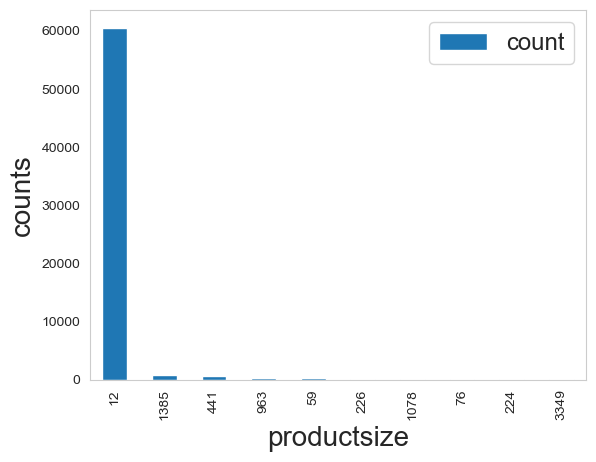

In [10]:
ax=sum_of_productsize.plot(y='count', kind='bar',grid=False)
ax.set_xlabel('productsize', fontsize=20)
ax.set_ylabel('counts', fontsize=20)
# ax.ylim(0, 0.4)
ax.legend(loc='upper right',fontsize="xx-large")
# plt.savefig('result/SARS2.productszie.png', dpi=1200,bbox_inches = 'tight')
plt.show()

In [11]:
lda_mg = largedel_anno.groupby('startpos').agg({'count': 'sum', 'j5': 'first', 'j3': 'first','productsize': 'first'}).sort_values(by='count',ascending=False)
lda_mg.head(20)

,count,j5,j3,productsize
startpos,,,,
94,60502,6773,6793,12
20633,783,62,20620,1385
26375,662,66,26360,441
17745,241,63,17740,963
9032,219,61,8985,59
25683,161,66,25672,226
17400,123,62,17353,1078
25445,94,57,25426,76
24790,92,61,24750,224


In [12]:
(largedel_anno['j3'] - largedel_anno['j5']).min()

20

In [13]:
#排除 largedel_anno DataFrame 中起始和结束位置与 BLACKLIST 中定义的位置相匹配的行，并计算剔除后的行的计数总和
BLACKLIST = [
    [26256, 26283], # mixed substrain with partial deletion in genomic RNA
]

for blkstart, blkend in BLACKLIST:
    largedel_anno = largedel_anno[~((largedel_anno['j5'] == blkstart) &
                                    (largedel_anno['j3'] == blkend))]
largedel_anno['count'].sum()

63888

In [14]:
CANONICAL_START = 59 # 0-based, inc
CANONICAL_END = 80 # 0-based, noninc

is_cano = largedel_anno['j5'].between(CANONICAL_START, CANONICAL_END-1)
ld_cano = largedel_anno[is_cano]
ld_noncano = largedel_anno[~is_cano]

ld_cano['count'].sum(), ld_noncano['count'].sum()
# ld_cano

(3262, 60626)

In [15]:
cdsanno

,chrom,type,name,start,end
0,MK584552.1,CDS,ORF1a,293,12601
1,MK584552.1,CDS,ORF1b,12601,20637
2,MK584552.1,CDS,S,20633,24791
3,MK584552.1,CDS,ORF3a,24790,25465
4,MK584552.1,CDS,E,25445,25676
5,MK584552.1,CDS,M,25683,26364
6,MK584552.1,CDS,N,26375,27701


In [16]:
can_prod = pd.merge(ld_cano, cdsanno, left_on='startpos', right_on='start')
can_prod = can_prod[can_prod['name'].notnull()]
can_prod['count'].sum()

1698

In [17]:
can_prod.groupby('name').agg({'count': 'sum'}).sort_values(by='count', ascending=False)

,count
name,
S,783
N,662
M,161
ORF3a,92


In [18]:
can_nonprod = pd.merge(ld_cano, cdsanno, left_on='startpos', right_on='start', how='left')
can_nonprod = can_nonprod[can_nonprod['name'].isnull()]
can_nonprod

,j5,j3,count,startpos,productsize,chrom,type,name,start,end
2,63,17740,208,17745,963,NaN,NaN,NaN,NaN,NaN
3,61,8985,206,9032,59,NaN,NaN,NaN,NaN,NaN
4,62,17353,111,17400,1078,NaN,NaN,NaN,NaN,NaN
8,65,14166,40,14190,2148,NaN,NaN,NaN,NaN,NaN
9,65,18130,37,18148,12,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
359,69,5261,1,5285,15,NaN,NaN,NaN,NaN,NaN
360,70,17387,1,17400,1078,NaN,NaN,NaN,NaN,NaN
361,70,17747,1,17845,46,NaN,NaN,NaN,NaN,NaN
362,70,19486,1,19504,4,NaN,NaN,NaN,NaN,NaN


In [19]:
from matplotlib.patches import Rectangle

In [20]:
def common_tune(ax):
    ax.set_xlim(-.1, 29950)
    ax.set_ylim(-12, 12)

    for spname in 'top left right'.split():
        ax.spines[spname].set_visible(False)
    plt.setp(ax.get_yticklines(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

In [21]:
ANCHOR_TOP = 1.5
ANCHOR_BOTTOM = -1.5
APEX_TOP = 9
APEX_BOTTOM = -9

def draw_bar(ax):
    for _, row in cdsanno.iterrows():
        if row['name'].startswith('nsp'):
            continue
        rect = Rectangle((row['start'], ANCHOR_BOTTOM), row['end'] - row['start'], ANCHOR_TOP-ANCHOR_BOTTOM, fc=orfcolors[row['name']])
        ax.add_patch(rect)

    rect = Rectangle((0, ANCHOR_BOTTOM), 265, ANCHOR_TOP-ANCHOR_BOTTOM, fc='#505050')
    ax.add_patch(rect)
    rect = Rectangle((265, ANCHOR_BOTTOM), 13441-265, ANCHOR_TOP-ANCHOR_BOTTOM, fc='#c5d9ea')
    ax.add_patch(rect)
    rect = Rectangle((13441, ANCHOR_BOTTOM), 21552-13441, ANCHOR_TOP-ANCHOR_BOTTOM, fc='#e8d2c4')
    ax.add_patch(rect)
    rect = Rectangle((27701, ANCHOR_BOTTOM), 28044-27701, ANCHOR_TOP-ANCHOR_BOTTOM, fc='#d0d0d0')
    ax.add_patch(rect)

In [22]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches
Path = mpath.Path

In [23]:
def draw_junction(ax, start, end, top, height_coef=1, **kwds):
    distance = (end - start)

    height = max(1, height_coef * .015 * distance ** .6)
    curve = 3 * height ** .5
    pleft = start + distance / curve
    pmid = start + distance / 2
    pright = start + distance * (curve - 1) / curve
    anchor = ANCHOR_TOP if top else ANCHOR_BOTTOM
    apex = ANCHOR_TOP+height if top else ANCHOR_BOTTOM-height

    if 'edgecolor' in kwds:
        pass
    elif top:
        kwds['edgecolor'] = '#364fc7'
    else:
        kwds['edgecolor'] = '#c92a2a'
    pp1 = mpatches.PathPatch(
        Path([(start, anchor), (pleft, apex), (pmid, apex), (pright, apex), (end, anchor)],
             [Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.CURVE3, Path.MOVETO]),
        fc="none", transform=ax.transData, **kwds)
    ax.add_patch(pp1)

In [24]:
ALPHA_MAP = [
    [1000, 1.0],
    [500, 0.5],
    [200, 0.3],
    [100, 0.2],
    [50, 0.1],
    [0, 0.01]
]
def calc_alpha(jnc):
    for mincnt, alpha in ALPHA_MAP:
        if jnc['count'] >= mincnt:
            return alpha
    return 0

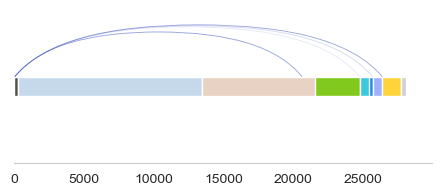

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5.4, 2))

draw_bar(ax)

for _, jnc in can_prod.iloc[:100].iterrows():
    alpha = calc_alpha(jnc)
    draw_junction(ax, jnc.j5, jnc.j3, top=True,
                  alpha=alpha, height_coef=1.2, lw=.6)

common_tune(ax)
plt.grid(False)
# plt.savefig('result/plot-canonical.pdf',dpi=1200)
# plt.savefig('result/plot-canonical.png',dpi=1200)

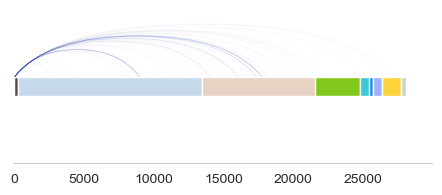

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5.4, 2))

draw_bar(ax)

for _, jnc in can_nonprod.iloc[:100].iterrows():
    alpha = calc_alpha(jnc)
    draw_junction(ax, jnc.j5, jnc.j3, top=True,
                  alpha=alpha, height_coef=1.2, lw=.6)

common_tune(ax)
plt.grid(False)
plt.savefig('result/plot-noncanonical.pdf',dpi=1200)
plt.savefig('result/plot-noncanonical.png',dpi=1200)

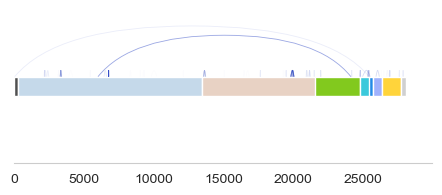

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5.4, 2))

draw_bar(ax)

for _, jnc in ld_noncano.iloc[:100].iterrows():
    alpha = calc_alpha(jnc)
    draw_junction(ax, jnc.j5, jnc.j3, top=True,
                  alpha=alpha, height_coef=1.2, lw=.6)

common_tune(ax)
plt.grid(False)
plt.savefig('result/plot-nold-noncanonical.pdf',dpi=1200)
plt.savefig('result/plot-nold-noncanonical.png',dpi=1200)

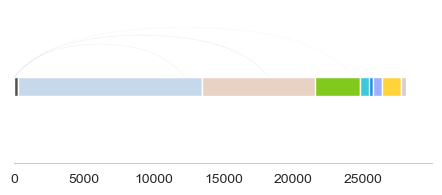

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5.4, 2))

draw_bar(ax)

for _, jnc in newdata1.iloc[:100].iterrows():
    alpha = calc_alpha(jnc)
    draw_junction(ax, jnc.j5, jnc.j3, top=True,
                  alpha=alpha, height_coef=1.2, lw=.6)

common_tune(ax)
plt.grid(False)
# plt.savefig('result/plot-productsize9.pdf',dpi=1200)
# plt.savefig('result/plot-productsize9.png',dpi=1200)